In [52]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import lecture02

#names = lecture02.names_dataset()
names = open("names.txt").read().split()
names = names

chars = sorted(set("".join(names)))
stoi = {s: i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(stoi)
print(itos)
print(names)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn', 'abigail', 'emily', 'elizabeth', 'mila', 'ella', 'avery', 'sofia', 'camila', 'aria', 'scarlett', 'victoria', 'madison', 'luna', 'grace', 'chloe', 'penelope', 'layla', 'riley', 'zoey', 'nora', 'lily', 'eleanor', 'hannah', 'lillian', 'addison', 'aubrey', 'ellie', 'stella', 'natalie', 'zoe', 'leah', 'hazel', 'violet', 'aurora', 'savannah', 'audrey', 'brooklyn', 'bella', 'claire', 'skylar', 'lucy', 'paisley', 'everly', 'anna', 'caroline', 'nova', 'genesis', 'emilia', 'kennedy', 'samantha', 'maya', 'willow', 'kinsley', 'naomi', 'aaliyah', 'elena', 'sarah', 'ariana', 'allison', 'gabriella', 'alice', 'madelyn', 'cora', 'ruby', 'eva', 'serenity', 'autumn', 'adeline', 

In [ ]:

block_size = 4

def build_dataset(words):
    X, Y = [], []

    for word in words:
        context = [0] * block_size
        for ch in word + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y

import random
random.seed(42)
random.shuffle(names)
n1 = int(0.8*len(names))
n2 = int(0.9*len(names))

Xtr, Ytr = build_dataset(names[:n1])
Xdev, Ydev = build_dataset(names[n1:n2])
Xte, Yte = build_dataset(names[n2:])

print(Xtr.size())
print(Xdev.size())
print(Xte.size())


torch.Size([182580, 3])
torch.Size([22767, 3])
torch.Size([22799, 3])


In [115]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, 20),generator=g)
W1 = torch.randn((60,300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

C

tensor([[ 1.5674e+00, -2.3729e-01, -2.7385e-02, -1.1008e+00,  2.8588e-01,
         -2.9643e-02, -1.5471e+00,  6.0489e-01,  7.9136e-02,  9.0462e-01,
         -4.7125e-01,  7.8682e-01, -3.2843e-01, -4.3297e-01,  1.3729e+00,
          2.9334e+00,  1.5618e+00, -1.6261e+00,  6.7716e-01, -8.4039e-01],
        [ 9.8488e-01, -1.4837e-01, -1.4795e+00,  4.4830e-01, -7.0730e-02,
          2.4968e+00,  2.4448e+00, -6.7006e-01, -1.2199e+00,  3.0314e-01,
         -1.0725e+00,  7.2762e-01,  5.1114e-02,  1.3095e+00, -8.0220e-01,
         -8.5042e-01, -1.8068e+00,  1.2523e+00, -1.2256e+00,  1.2165e+00],
        [-9.6478e-01, -2.3211e-01, -3.4762e-01,  3.3244e-01, -1.3263e+00,
          1.1224e+00,  5.9641e-01,  4.5846e-01,  5.4011e-02, -1.7400e+00,
          1.1560e-01,  8.0319e-01,  5.4108e-01, -1.1646e+00,  1.4756e-01,
         -1.0006e+00,  3.8012e-01,  4.7328e-01, -9.1027e-01, -7.8305e-01],
        [ 1.3506e-01, -2.1161e-01, -1.0406e+00, -1.5367e+00,  9.3743e-01,
         -8.8303e-01,  1.7457e+00, 

In [116]:

lri = []
lossi = []
stepi = []

for i in range(200000):
    ix = torch.randint(0, Xtr.shape[0], (32,))

    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 60) @ W1+b1)
    logits = (h @ W2 + b2)
    loss = F.cross_entropy(logits, Ytr[ix])

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    stepi.append(i)
    lossi.append(loss.log10().item())
print(loss.item())

2.222031354904175


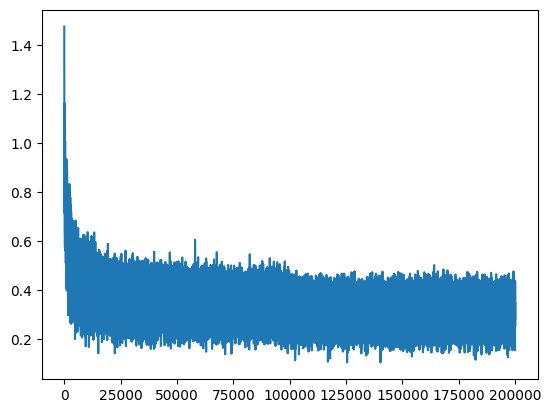

In [117]:
plt.plot(stepi, lossi)

In [119]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 60) @ W1 + b1)
logits = (h@W2+b2)
loss = F.cross_entropy(logits, Ytr)
loss.item()

2.0696332454681396

In [120]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 60) @ W1 + b1)
logits = (h@W2+b2)
loss = F.cross_entropy(logits, Ydev)
loss


tensor(2.1466, grad_fn=<NllLossBackward0>)

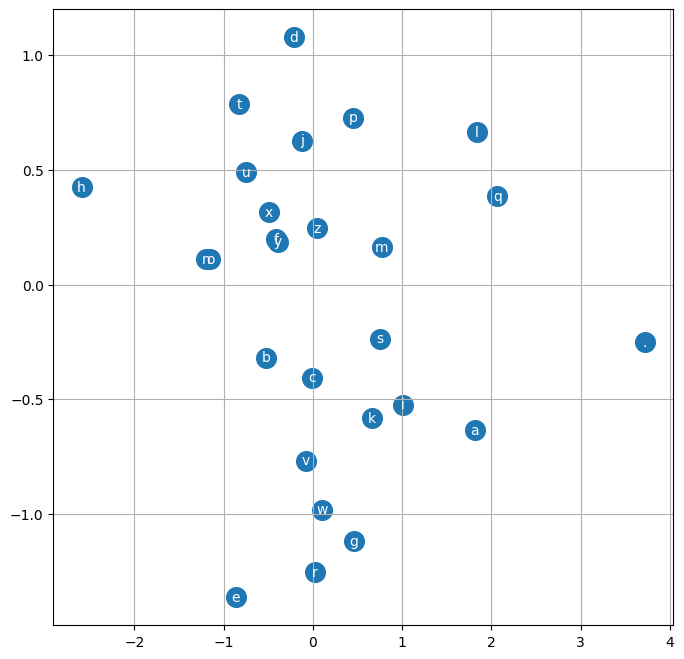

In [121]:
plt.figure(figsize=(8,8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid("minor")

In [24]:
print(C.shape)
print(vocab_size)
print(len(itos.keys()))
C

torch.Size([27, 2])
27
27


tensor([[-0., -0.],
        [-0., -0.],
        [-0., -0.],
        [-0., -0.],
        [-0., -0.],
        [-0., -0.],
        [-0., -0.],
        [-0., -0.],
        [-0., -0.],
        [-0., -0.],
        [-0., -0.],
        [-0., -0.],
        [-0., -0.],
        [-0., -0.],
        [-0., -0.],
        [-0., -0.],
        [-0., -0.],
        [-0., -0.],
        [-0., -0.],
        [-0., -0.],
        [-0., -0.],
        [-0., -0.],
        [-0., -0.],
        [-0., -0.],
        [-0., -0.],
        [-0., -0.],
        [-0., -0.]], requires_grad=True)

In [37]:
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
